In [1]:
#https://www.kdnuggets.com/2020/12/implementing-adaboost-algorithm-from-scratch.html
#https://github.com/jinxin0924/multi-adaboost/blob/master/multi_AdaBoost.py

In [56]:
from sklearn.datasets import make_gaussian_quantiles
import numpy as np
import pandas as pd
from numpy.random import choice

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [3]:
heart_data = pd.read_csv("heart.csv")

In [4]:
heart_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

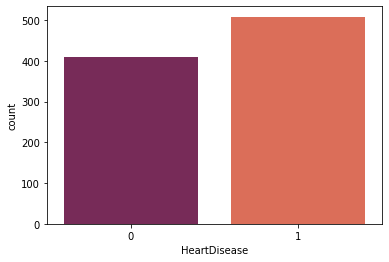

In [7]:

sns.countplot(x = heart_data['HeartDisease'], data = heart_data, palette='rocket')

In [ ]:
#Dataset is overall balanced (not noisy data)

In [10]:

le=LabelEncoder()

heart_data['Sex']=le.fit_transform(heart_data['Sex'])
heart_data['RestingECG']=le.fit_transform(heart_data['RestingECG'])
heart_data['ChestPainType']=le.fit_transform(heart_data['ChestPainType'])
heart_data['ExerciseAngina']=le.fit_transform(heart_data['ExerciseAngina'])
heart_data['ST_Slope']=le.fit_transform(heart_data['ST_Slope'])

heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [70]:
X = heart_data.drop('HeartDisease', axis=1)
y = heart_data['HeartDisease']

y = np.where(y==0,-1,1)


In [71]:
#make a binary 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [72]:
#------------------------------- BINARY CLASSIFICATIONS ---------------------- #

class BinaryClassAdaboost():
    """
    """
    
    def __init__(self, n_estimators:int):
        """
        Initialialisation of Adaboost class
        Parameters: 
            n_estimators: int:  number of weak learners 
        """
        self.n_estimators = n_estimators
        self.list_WL = [] #list with model
        self.list_alpha = [] #list with weight of model 
        self.estimator_errors = []

        
        
    def fit(self, X, y):
        """
        Fit model 
        Parameters: 
            X: array: data
            y: array: vector of class labels where yi E Y= {1,..., k} and k = 2
        """
        ## Step 1: Initialize the weights to a constant
        n_samples = X.shape[0]                
        w = []
        ##Weights are initialized to 1/Number of samples: 
        w_t = [1/n_samples for x in range(n_samples)]       
              
        
        ## Step 2: Classify with ramdom sampling of data using a weak learner
        #Construction des weaklearner
        
        #for each weak learner
        for t in range(self.n_estimators):

            #Choose and Call the Base/Weak learner
            #A decision tree with one depth has one node and is called a stump or weak learner
            WL = DecisionTreeClassifier(max_depth=1)
            #Fit the stump model with the ramdom samples
            WL.fit(X, y, sample_weight=w_t)
            #Get the predicted classes
            y_pred = WL.predict(X)
            
            ##Step 3: Compute error of weak learner
            eps = self.error_wl(w_t, y_pred, y)
        
            # if the error of the weak learner is higher then 0.5 (worse then random guess) 
            #don't take into account this learner weight
            if eps > 0.5:
                break
            
            #Step 4: Calculate the performance of the weak learner
            #Performance of the weak learner(α) = 0.5* ln (1 – error/error)
            #Calculate alpha for this weak learner
            
            alpha_t = 0.5 * np.log((1- eps) / eps)

            #Step 5: Update weight
            #With the alpha performance (α) the weights of the wrongly classified records are increased
            #and the weights of the correctly classified records decreased.
            y_temp = np.multiply(y, y_pred)
            y_temp2 = -alpha_t * y_temp 
            normalized_w_t = np.multiply(w_t, np.exp(y_temp2))

            #normalizing the weigths for the sum to be equal do 1
            w_t = normalized_w_t / sum(normalized_w_t)
            
            #store the alpha performance of each weak learner
            self.list_alpha.append(alpha_t)
            #store each weak learner
            self.list_WL.append(WL)
            self.estimator_errors.append(eps)

            
            
        return self

    def predict(self, X):
        """
        predict output of Adaboost 
        Paramters: 
            X: array: data
        Return: 
            y_pred: array: data
        """
        #The final prediction is a compromise between all the weak learners predictions
        list_y_pred = []
        
        #for each weak learner get their prediction

        for WL, w in zip(self.list_WL, self.list_alpha):
            #Final prediction is obtained by the weighted by alpha sum of each weak learner prediction
            list_y_pred.append(WL.predict(X) * w)
         
        #the array of all the predictions

        arr_y_pred = np.array(sum(list_y_pred))
 
        #get -1 if y_pred < 0 or 1 if y_pred > 0
        y_pred = np.sign(arr_y_pred)
        
        return y_pred 
        
    def error_wl(self, w_t, y_pred, y):
        """
        error of current weaklearner
        Parameters:
            w_t: array:  weight of observation
            y_pred: array: output of wl 
            y: array: labels
        Return: 
            eps: float: error of wl 
        """
        
        ind_err = []
        for i in range(y_pred.shape[0]):
            if y_pred[i] != y[i]:
                ind_err.append(1) 
            else: 
                ind_err.append(0) 
    
        w_ind_err = np.multiply(w_t,ind_err)
        
        eps = np.sum(w_ind_err)
    
        return eps
    
        

In [76]:
model = BinaryClassAdaboost(50)
model.fit(X_train, y_train)

In [74]:
#------------------------------- BINARY CLASSIFICATIONS ---------------------- #

class BinaryClassAdaboostSampling():
    """
    """
    
    def __init__(self, n_estimators:int):
        """
        Initialialisation of Adaboost class
        Parameters: 
            n_estimators: int:  number of weak learners 
        """
        self.n_estimators = n_estimators
        self.list_WL = [] #list with model
        self.list_alpha = [] #list with weight of model 
        self.estimator_errors = []

        
        
    def fit(self, X, y):
        """
        Fit model 
        Parameters: 
            X: array: data
            y: array: vector of class labels where yi E Y= {1,..., k} and k = 2
        """
        ## Step 1: Initialize the weights to a constant
        n_samples = X.shape[0]                
        w = []
        ##Weights are initialized to 1/Number of samples: 
        w_t = [1/n_samples for x in range(n_samples)]       
              
        
        ## Step 2: Classify with ramdom sampling of data using a weak learner
        #Construction des weaklearner
        
        #for each weak learner
        for t in range(self.n_estimators):
            
            X_sample, y_sample = self.sampling(X, y, w_t)
            #Choose and Call the Base/Weak learner
            #A decision tree with one depth has one node and is called a stump or weak learner
            WL = DecisionTreeClassifier(max_depth=1)
            #Fit the stump model with the ramdom samples
            WL.fit(X_sample, y_sample)
            #Get the predicted classes
            y_pred = WL.predict(X)
            
            ##Step 3: Compute error of weak learner
            eps = self.error_wl(w_t, y_pred, y)
        
            # if the error of the weak learner is higher then 0.5 (worse then random guess) 
            #don't take into account this learner weight
            if eps > 0.5:
                break
            
            #Step 4: Calculate the performance of the weak learner
            #Performance of the weak learner(α) = 0.5* ln (1 – error/error)
            #Calculate alpha for this weak learner
            
            alpha_t =  eps/(1- eps)
            

            #Step 5: Update weight
            #With the alpha performance (α) the weights of the wrongly classified records are increased
            #and the weights of the correctly classified records decreased.
            y_temp = np.multiply(y, y_pred)
            y_temp2 = -alpha_t * y_temp 
            normalized_w_t = np.multiply(w_t, np.exp(y_temp2))

            #normalizing the weigths for the sum to be equal do 1
            w_t = normalized_w_t / sum(normalized_w_t)
            
            #store the alpha performance of each weak learner
            self.list_alpha.append(alpha_t)
            #store each weak learner
            self.list_WL.append(WL)
            self.estimator_errors.append(eps)

            
            
        return self

    def predict(self, X):
        """
        predict output of Adaboost 
        Paramters: 
            X: array: data
        Return: 
            y_pred: array: data
        """
        #The final prediction is a compromise between all the weak learners predictions
        list_y_pred = []
        
        #for each weak learner get their prediction

        for WL, w in zip(self.list_WL, self.list_alpha):
            #Final prediction is obtained by the weighted by alpha sum of each weak learner prediction
            list_y_pred.append(WL.predict(X) * w)
         
        #the array of all the predictions

        arr_y_pred = np.array(sum(list_y_pred))
 
        #get -1 if y_pred < 0 or 1 if y_pred > 0
        y_pred = np.sign(arr_y_pred)
        
        return y_pred 
        
    def error_wl(self, w_t, y_pred, y):
        """
        error of current weaklearner
        Parameters:
            w_t: array:  weight of observation
            y_pred: array: output of wl 
            y: array: labels
        Return: 
            eps: float: error of wl 
        """
        
        ind_err = []
        for i in range(y_pred.shape[0]):
            if y_pred[i] != y[i]:
                ind_err.append(1) 
            else: 
                ind_err.append(0) 
    
        w_ind_err = np.multiply(w_t,ind_err)
        
        eps = np.sum(w_ind_err)
    
        return eps
    
    def sampling(self, X, y, w_t):
            """
            sampling X with w_t 
            Parameters:
                X: array: data
                y: array: labels
                w_t: array: weigth
            Return:
                X_sample: array: sample of X
                y_sample: array: labels corresponding to X_sample
            """
            #put X and y in same array to sample 
            print(y.shape)
            print(X.shape)
            
            y_temp = np.array(y).reshape(y.shape[0],1)
            data = np.hstack((X, y_temp))
            #size of sample
            size = int(0.75*X.shape[0])
            #print(w_t)
            
            #sample
            sample = choice([x for x in range(data.shape[0])], size, w_t)
            #ch = choice([x for x in range(data.shape[0])], size, [1 for x in range(data.shape[0])])
            sample = data[sample,:]

            y_sample = sample[:,-1]
            X_sample = sample[:,:-1]        
            print(X_sample.shape)
            print(y_sample)
            return X_sample, y_sample

In [94]:
model = BinaryClassAdaboostSampling(50)
model.fit(X_train, y_train)

(3000,)
(3000, 10)
(2250, 10)
[2. 1. 2. ... 0. 0. 0.]


In [95]:
y_test.shape

(10000,)

In [96]:
model.estimator_errors

[]

In [78]:
y_pred = model.predict(X_test)

In [79]:
accuracy_score(y_test, y_pred)

0.8396739130434783

In [87]:
#-------------------------------Multiclass LASSIFICATIONS ---------------------- #


class MultiClassAdaBoost(object):
    '''
    Parameters
    -----------
    base_estimator: object
        The base model from which the boosted ensemble is built.
    n_estimators: integer, optional(default=50)
        The maximum number of estimators
    learning_rate: float, optional(default=1)
    Attributes
    -------------
    estimators_: list of base estimators
    estimator_weights_: array of floats
        Weights for each base_estimator
    estimator_errors_: array of floats
        Classification error for each estimator in the boosted ensemble.
    '''

    def __init__(self, n_estimators, learning_rate):
        self.n_estimators = n_estimators
        self.list_WL = [] #list with model
        self.list_alpha = [] #list with weight of model 
        self.learning_rate_ = learning_rate
        self.estimator_errors = []


    def fit(self, X, y):
        
        ## Step 1: Initialize the weights to a constant
        n_samples = X.shape[0]                
        w = []
        ##Weights are initialized to 1/Number of samples: 
        w_t = [1/n_samples for x in range(n_samples)]       
        
        # So in boost we have to ensure that the predict results have the same classes sort
        self.classes_ = np.array(sorted(list(set(y))))
        self.n_classes_ = len(self.classes_)
        
        
        ## Step 2: Classify with ramdom sampling of data using a weak learner
        #Construction des weaklearner
        
        #for each weak learner
        for t in range(self.n_estimators):
          
            #Choose and Call the Base/Weak learner
            #A decision tree with one depth has one node and is called a stump or weak learner
            WL = DecisionTreeClassifier(max_depth=1)
            #Fit the stump model with the ramdom samples
            WL.fit(X, y, sample_weight=w_t)
            
            y_pred = WL.predict(X)
            
            ##Step 3: Compute error of weak learner
            incorrect = y_pred != y
            estimator_error = np.dot(incorrect, w_t) / np.sum(w_t, axis=0)
            
            # if worse than random guess, stop boosting
            #if estimator_error >= 1 - 1 / self.n_classes_:
            if estimator_error >0.5:
                break

            # update alphe performance
            alpha_t = self.learning_rate_ * np.log((1 - estimator_error) / estimator_error) + np.log(
            self.n_classes_ - 1)
        

            # update sample weight
            w_t *= np.exp(alpha_t * incorrect)
            sample_weight_sum = np.sum(w_t, axis=0)

            # normalize sample weight
            w_t /= sample_weight_sum
            
            #store the alpha performance of each weak learner
            self.list_alpha.append(alpha_t)
            #store each weak learner
            self.list_WL.append(WL)
            # append error
            self.estimator_errors.append(estimator_error)

        return self


    def predict(self, X):
        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]

        
        pred = sum((estimator.predict(X) == classes).T * w
                   for estimator, w in zip(self.list_WL,
                                           self.list_alpha))

        pred /= sum(self.list_alpha)
        if n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)

        return self.classes_.take(np.argmax(pred, axis=1), axis=0)

In [93]:
X, y = make_gaussian_quantiles(
    n_samples=13000, n_features=10, n_classes=3, random_state=1
)

n_split = 3000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]


In [88]:
model = MultiClassAdaBoost(50, 0.001)

In [89]:
model.fit(X_train,y_train)

In [90]:
model.estimator_errors

[0.1890909090909091,
 0.18931425566189644,
 0.18953758073001337,
 0.18976088395042062,
 0.18998416497888615,
 0.19020742347178698,
 0.19043065908610937,
 0.19065387147944998,
 0.19087706031001675,
 0.19110022523663023,
 0.19132336591872362,
 0.19154648201634444,
 0.19176957319015486,
 0.191992639101433,
 0.1922156794120734,
 0.19243869378458822,
 0.1926616818821079,
 0.19288464336838188,
 0.19310757790777966,
 0.1933304851652915,
 0.1935533648065291,
 0.1937762164977267,
 0.19399903990574166,
 0.1942218346980552,
 0.19444460054277318,
 0.1946673371086273,
 0.19489004406497518,
 0.19511272108180125,
 0.19533536782971805,
 0.1955579839799664,
 0.1957805692044163,
 0.19600312317556762,
 0.19622564556655078,
 0.19644813605112754,
 0.1966705943036916,
 0.19689301999926936,
 0.19711541281352052,
 0.19733777242273878,
 0.19756009850385237,
 0.197782390734425,
 0.19800464879265617,
 0.19822687235738207,
 0.198449061108076,
 0.1986712147248491,
 0.19889333288845085,
 0.19911541528026988,
 0.199

In [91]:
y_pred = model.predict(X_test)

In [92]:
accuracy_score(y_test, y_pred)

0.8179347826086957

In [ ]:
## Explore Weak Learner (use different weak learners or with different parameters)


In [ ]:
## Explore Number of Trees


In [80]:
##Comparing with other algo

# Define dictionary with performance metrics

scores = ['accuracy','precision_weighted','recall_weighted','f1_weighted',]
# Instantiate the machine learning classifiers
log_model = LogisticRegression(max_iter=10000)
svc_model = LinearSVC(dual=False)
dtr_model = DecisionTreeClassifier()
rfc_model = RandomForestClassifier()
gnb_model = GaussianNB()
ada_model = AdaBoostClassifier()
#my_ada_model = MultiClassAdaBoost(100, 0.001)


# Define the models evaluation function
def models_evaluation(X, labels, folds):
    
    '''
    X : data set features
    labels : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    log = cross_validate(log_model, X, labels, cv=folds, scoring=scores)
    svc = cross_validate(svc_model, X, labels, cv=folds, scoring=scores)
    dtr = cross_validate(dtr_model, X, labels, cv=folds, scoring=scores)
    rfc = cross_validate(rfc_model, X, labels, cv=folds, scoring=scores)
    gnb = cross_validate(gnb_model, X, labels, cv=folds, scoring=scores)
    ada = cross_validate(ada_model, X, labels, cv=folds, scoring=scores)
    #my_ada = cross_validate(my_ada_model, X, labels, cv=folds, scoring=scores)

    
    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'Logistic Regression':[log['test_accuracy'].mean(),
                                                               log['test_precision_weighted'].mean(),
                                                               log['test_recall_weighted'].mean(),
                                                               log['test_f1_weighted'].mean()],
                                       
                                      'Support Vector Classifier':[svc['test_accuracy'].mean(),
                                                                   svc['test_precision_weighted'].mean(),
                                                                   svc['test_recall_weighted'].mean(),
                                                                   svc['test_f1_weighted'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision_weighted'].mean(),
                                                       dtr['test_recall_weighted'].mean(),
                                                       dtr['test_f1_weighted'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision_weighted'].mean(),
                                                       rfc['test_recall_weighted'].mean(),
                                                       rfc['test_f1_weighted'].mean()],
                                       
                                      'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),
                                                              gnb['test_precision_weighted'].mean(),
                                                              gnb['test_recall_weighted'].mean(),
                                                              gnb['test_f1_weighted'].mean()], 
                                       
                                       
                                       'Adaboost Classifier':[ada['test_accuracy'].mean(),
                                                              ada['test_precision_weighted'].mean(),
                                                              ada['test_recall_weighted'].mean(),
                                                              ada['test_f1_weighted'].mean()]
                                       },
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)
  
# Run models_evaluation function
models_evaluation(X, y, 10)

C:\Users\lfurtado\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\lfurtado\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\lfurtado\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\lfurtado\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\lfurtado\Anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\lfurtado\Anaconda3\lib\site-packages\sklearn\base.py:441

,Logistic Regression,Support Vector Classifier,Decision Tree,Random Forest,Gaussian Naive Bayes,Adaboost Classifier,Best Score
Accuracy,0.829945,0.827771,0.784161,0.848423,0.845210,0.850597,Adaboost Classifier
Precision,0.840108,0.837959,0.791158,0.857795,0.864803,0.858185,Gaussian Naive Bayes
Recall,0.829945,0.827771,0.784161,0.848423,0.845210,0.850597,Adaboost Classifier
F1 Score,0.828866,0.826751,0.783872,0.847470,0.842490,0.849575,Adaboost Classifier
